In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
import pandas as pd
import seaborn as sns 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)
print(py.__version__)



/home/mikejones/anaconda3/bin/python


Using TensorFlow backend.




1.14.0
2.5.6


In [2]:
tf.__version__

'1.14.0'

In [3]:
# load thermo and pairwise distance features seperately
# only pwd features are used to train the model, thermo are for plotting

thermo_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/thermo-2831-1000-10.npy')
pwd_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/pwdr-all_t-1000-5000-190.npy')[:300]

scaler = pre.MinMaxScaler(feature_range=(-1, 1))

scaler.fit(np.concatenate(thermo_features))
thermo_features_s = [scaler.transform(item) for item in thermo_features]

scaler.fit(np.concatenate(pwd_features))
pwd_features_s = [scaler.transform(item) for item in pwd_features]

print(np.shape(thermo_features))
print(np.shape(pwd_features))


(2831, 1000, 10)
(300, 5000, 190)


In [4]:
# define individual basepair distance features 

## HDE

In [5]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

n_sm = 6 

hde = HDE(190, n_components=n_sm, lag_time=lag_time // skip, dropout_rate=0, batch_size=500000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])


In [6]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [7]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(np.concatenate(pwd_features))


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1199992 samples, validate on 299998 samples
Epoch 1/100
1199992/1199992 [==============================] - 25s 21us/step - loss: -2.4170 - val_loss: -3.2747
Epoch 2/100
1199992/1199992 [==============================] - 23s 19us/step - loss: -3.7771 - val_loss: -4.3795
Epoch 3/100
1199992/1199992 [==============================] - 26s 22us/step - loss: -4.6321 - val_loss: -4.9465
Epoch 4/100
1199992/1199992 [==============================] - 24s 20us/step - loss: -5.0069 - val_loss: -5.1379
Epoch 5/100
1199992/1199992 [==============================] - 22s 18us/step - loss: -5.2076 - val_loss: -5.4730
Epoch 6/100
1199992/1199992 [==============================] - 25s 21us/step - loss: -5.6980 - val_loss: -5.9640
Epoch 7/100
1199992/1199992 [==============================] - 23s 19us/step - loss: -5.9017 - val_loss: -5.9695
Epoch 8/100

1199992/1199992 [==============================] - 25s 21us/step - loss: -6.8433 - val_loss: -6.8469
Epoch 67/100
1199992/1199992 [==============================] - 25s 21us/step - loss: -6.8475 - val_loss: -6.8513
Epoch 68/100
1199992/1199992 [==============================] - 25s 21us/step - loss: -6.8477 - val_loss: -6.6357
Epoch 69/100
1199992/1199992 [==============================] - 25s 20us/step - loss: -6.8113 - val_loss: -6.8326
Epoch 70/100
1199992/1199992 [==============================] - 27s 22us/step - loss: -6.8119 - val_loss: -6.7980
Epoch 71/100
1199992/1199992 [==============================] - 24s 20us/step - loss: -6.8064 - val_loss: -6.8211
Epoch 72/100
1199992/1199992 [==============================] - 26s 21us/step - loss: -6.8180 - val_loss: -6.8251
Epoch 73/100
1199992/1199992 [==============================] - 24s 20us/step - loss: -6.8248 - val_loss: -6.8340
Epoch 74/100
1199992/1199992 [==============================] - 26s 21us/step - loss: -6.8339 - val_l

HDE(activation=None, batch_normalization=True, batch_size=500000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7f5bc4224d30>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=10, latent_space_noise=0,
    learning_rate=0.01, n_components=6, n_epochs=100, validation_split=0.2,
    verbose=True)

In [8]:
hde_coords = [hde.transform(item) for item in pwd_features]
hde_timescales = hde.timescales_
print(hde_timescales)

[1607.90963539 1371.15057549  981.74197306  853.62137455  583.64562052
  363.45419794]


In [19]:
## make pandas data frame

skip = 314    #num coords to skip on plot
num_bp = 10

print (np.shape(hde_coords))
print (np.shape(pwd_features))

hde_coords_conc = np.concatenate(hde_coords)[::skip]
pwd_features_conc = np.concatenate(pwd_features)[::skip]

index_size = len(hde_coords_conc[:, 0])

print (np.shape(hde_coords_conc))
print (np.shape(pwd_features_conc))


hde_col_list = ['1st_EF', '2nd_EF', '3rd_EF', '4th_EF', '5th_EF', '6th_EF', '7th_EF']
df = pd.DataFrame(data    = hde_coords_conc, 
                  columns = hde_col_list[:n_sm],
                  index   = np.linspace(1, index_size, index_size))

#dict shows which indices need to be averaged in order to form their corresponding features
bp_match_dict  =  {'inter_ends':[9, 90],
                   'inter_cores':[45, 54],
                   'inter_all':[i*9 for i in range (num_bp)],
                   'intra_ends':[136, 181],
                   'intra_end_to_core':[110, 140, 155, 185]}


#adds each mean calculation to the dataframe where the dict key becomes the col name
for key in bp_match_dict:
    mean_vec = np.mean(pwd_features_conc[:, bp_match_dict[key]], axis=1)
    df[key] = mean_vec

    
'''

df_thermo =  pd.DataFrame(data    = thermo_features_conc, 
                   columns = feature_col_list, 
                   index   = np.linspace(1, index_size, index_size))

df = df_hde.join(df_thermo)
df = df.join(df_bp)

'''

print(df.head())

(300, 5000, 6)
(300, 5000, 190)
(4778, 6)
(4778, 190)
       1st_EF    2nd_EF    3rd_EF    4th_EF    5th_EF    6th_EF  inter_ends  \
1.0  1.208104  0.553644 -0.263426 -0.429910 -0.261982  0.112229    0.165396   
2.0  1.195983  0.539369 -0.297639 -0.520564 -0.148974  0.173337    0.154217   
3.0  1.191512  0.543063 -0.298549 -0.525417 -0.151213  0.159406    0.126928   
4.0  1.045671  0.687358 -0.330685 -0.162361 -0.214401  0.002057    0.103303   
5.0  1.514150  1.507177  0.788223  7.051763 -0.408719  0.146233    0.056403   

     inter_cores  inter_all  intra_ends  intra_end_to_core  
1.0     0.170184   0.154329    0.033407           0.056945  
2.0     0.165074   0.151784    0.032842           0.055262  
3.0     0.170496   0.147763    0.035929           0.057142  
4.0     0.159744   0.106390    0.028544           0.050381  
5.0     0.111237   0.091644    0.036657           0.053515  


In [41]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

def plot_subs(df, bp_match_dict, EF):
    
    plt.rcParams.update({'font.size': 32})
    dim = len(bp_match_dict)
    
    tPlot, axes = plt.subplots(
            nrows=dim, ncols=dim, sharex=True, sharey=False, figsize=[40, 40],
            gridspec_kw={'wspace':0.2, 'hspace': 0.2}
            )

    axes_labels = [0 for i in range(dim**2)]

    for j, k_i in enumerate(bp_match_dict):
        for i, k_j in enumerate(bp_match_dict):
            
            x = df[k_i]
            y = df[k_j]
            axes_labels[i*dim+j] = [k_i, k_j]
            color = df[EF]
            
            axes[i][j].scatter(x, y, c=color, cmap='inferno')


    for i, ax in enumerate(axes.flat):
        ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
        ax.label_outer()
            
    plt.show()
    

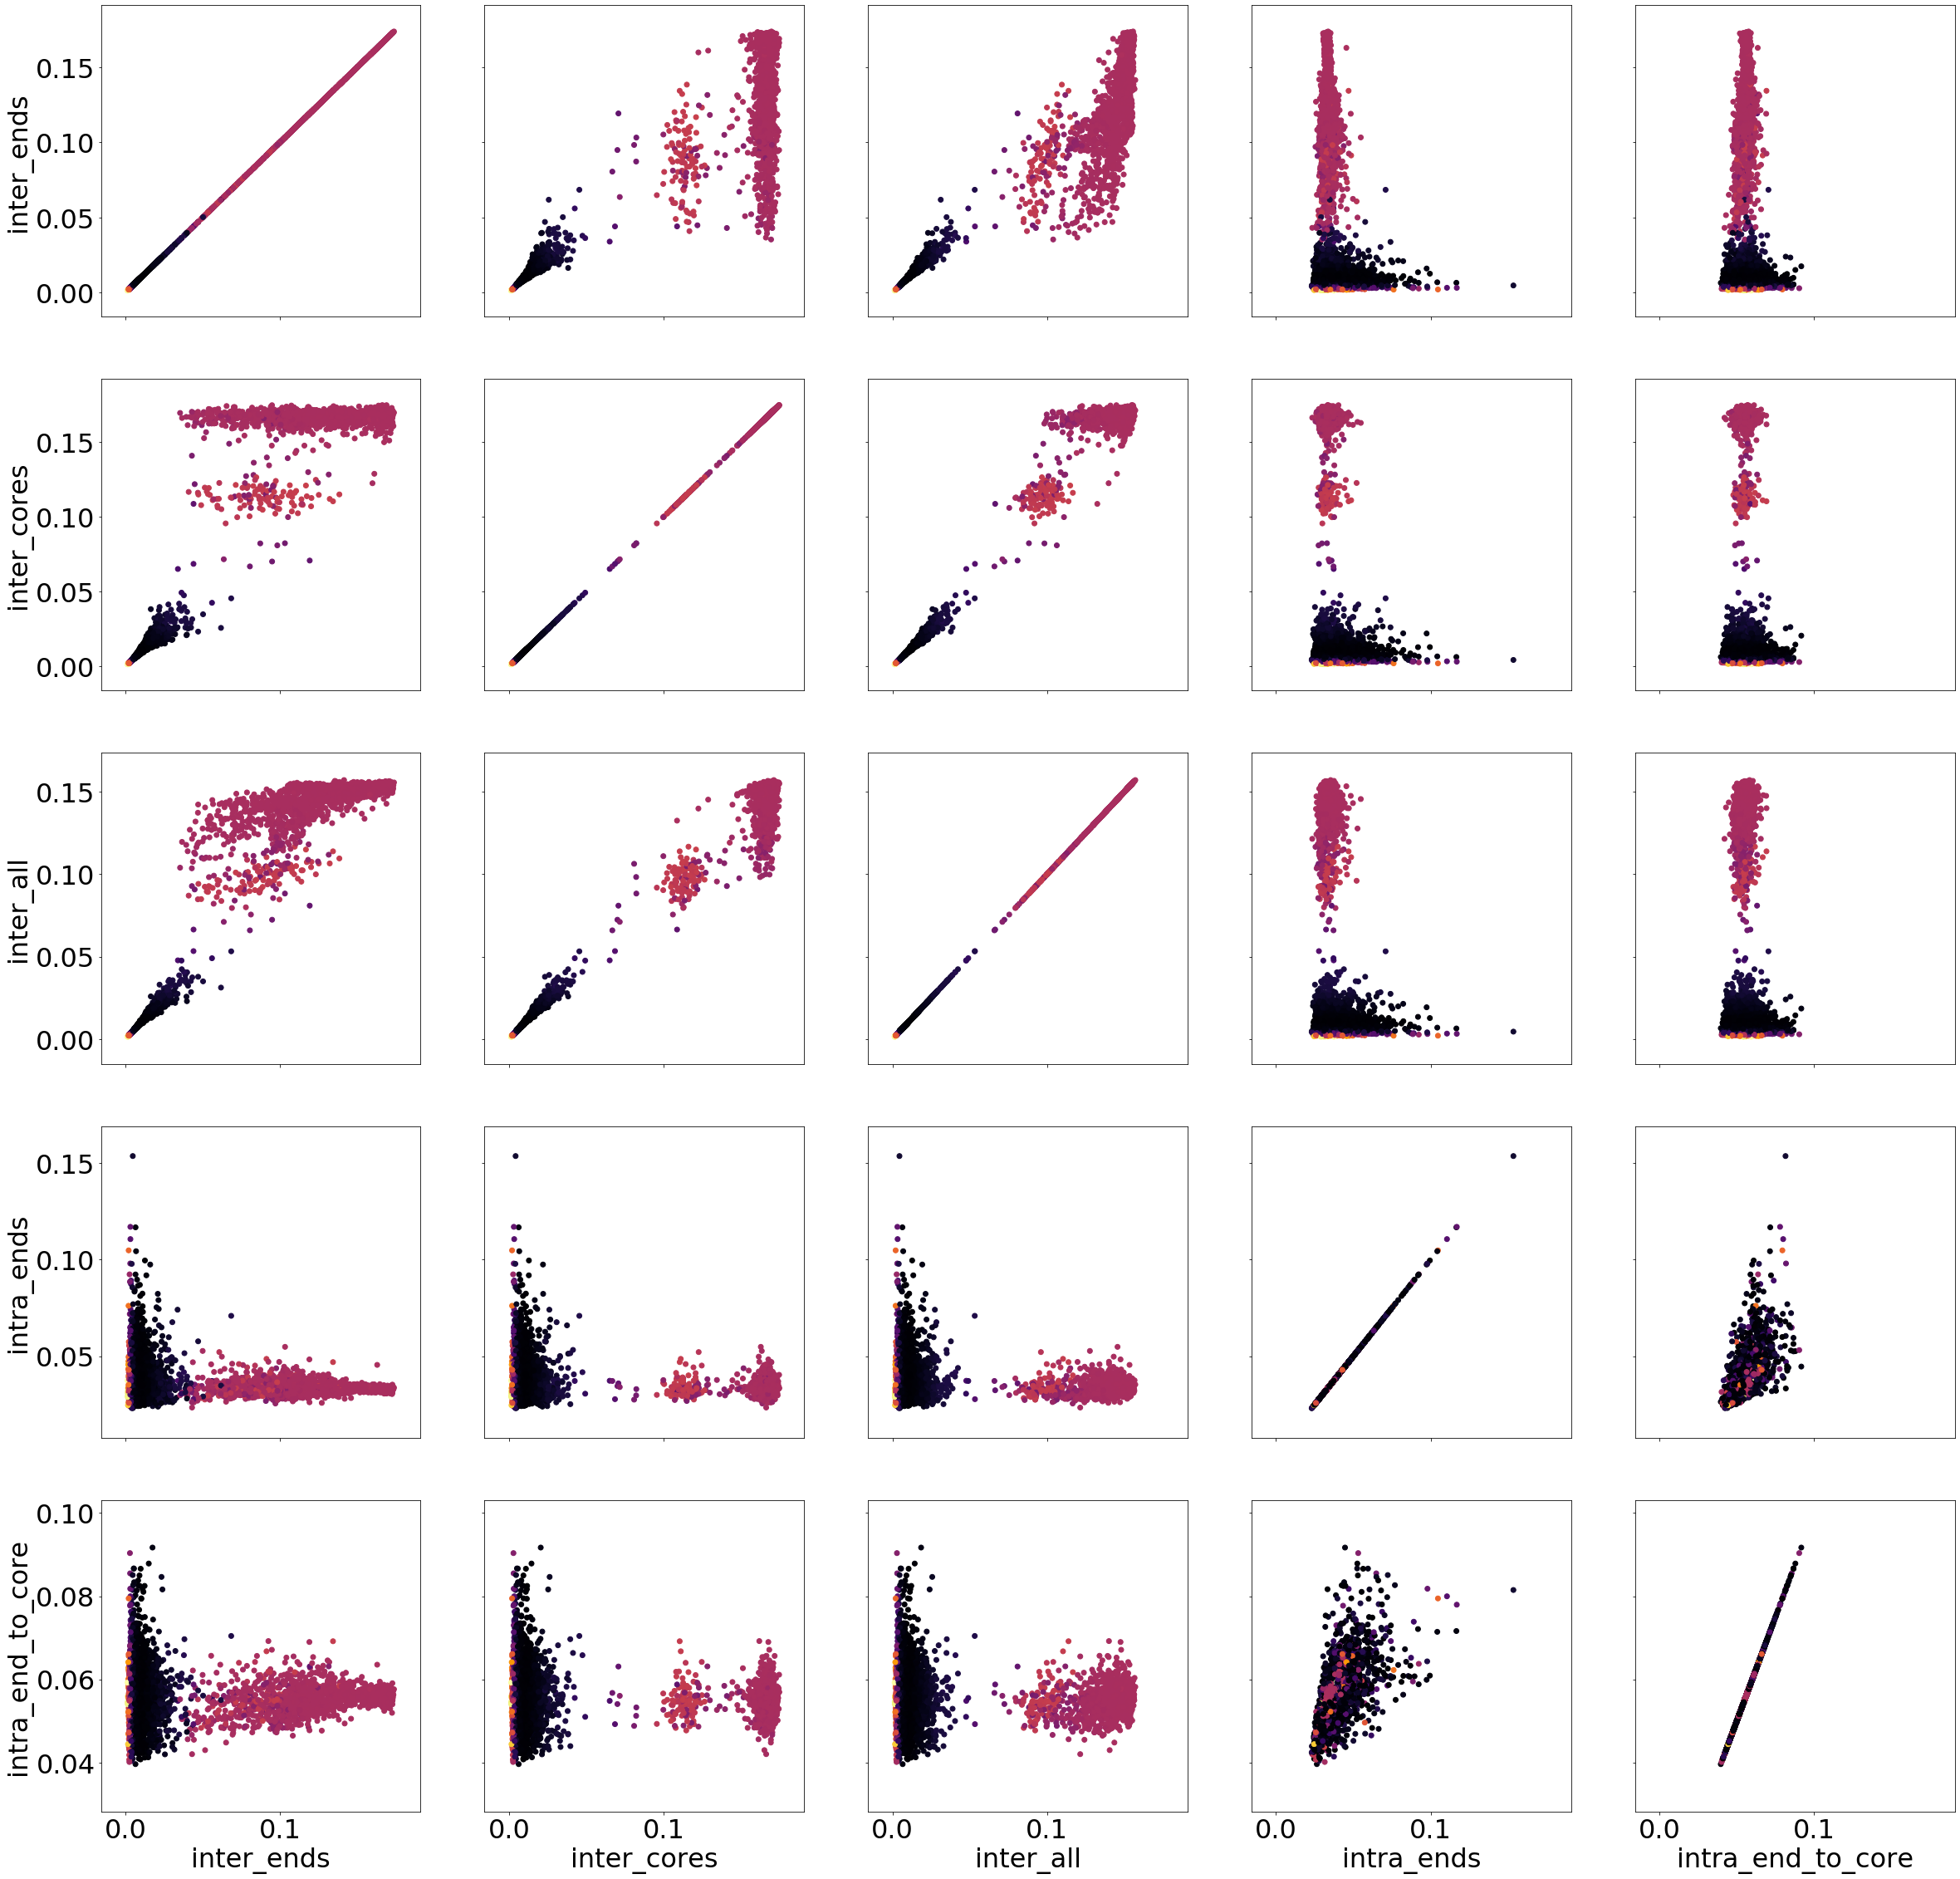

In [42]:
plot_subs(df, bp_match_dict, '1st_EF')

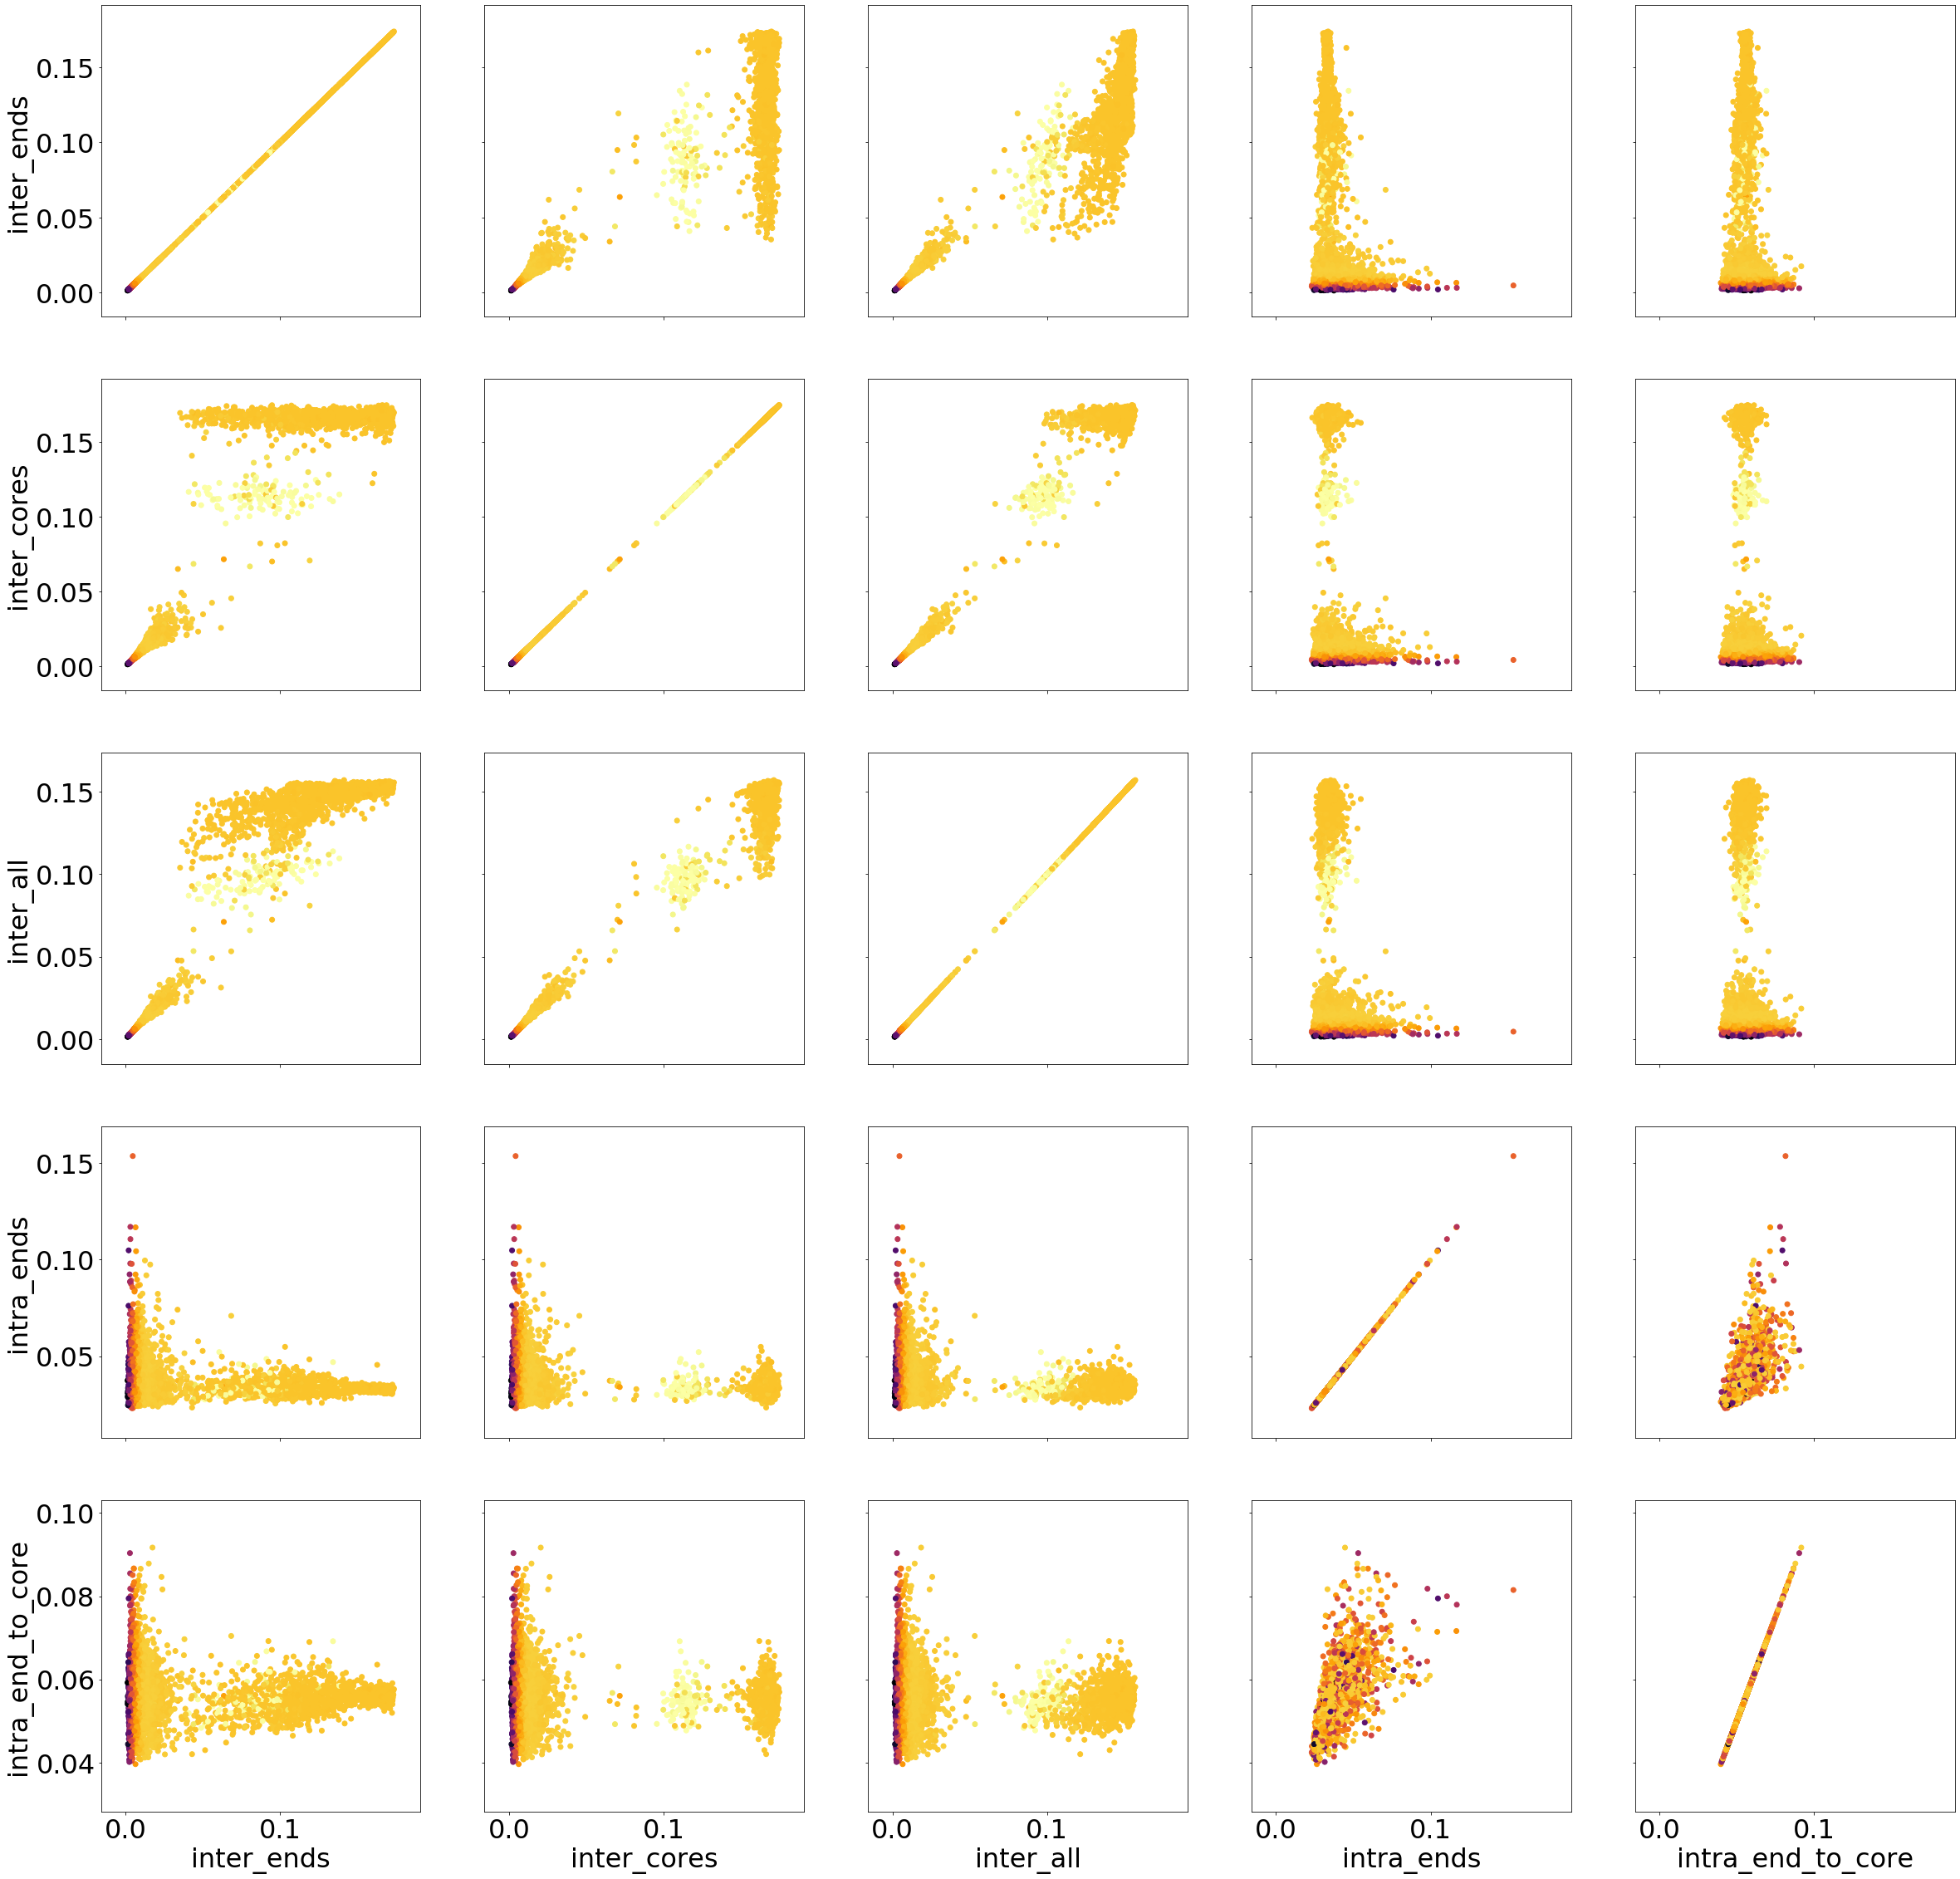

In [43]:
plot_subs(df, bp_match_dict, '2nd_EF')

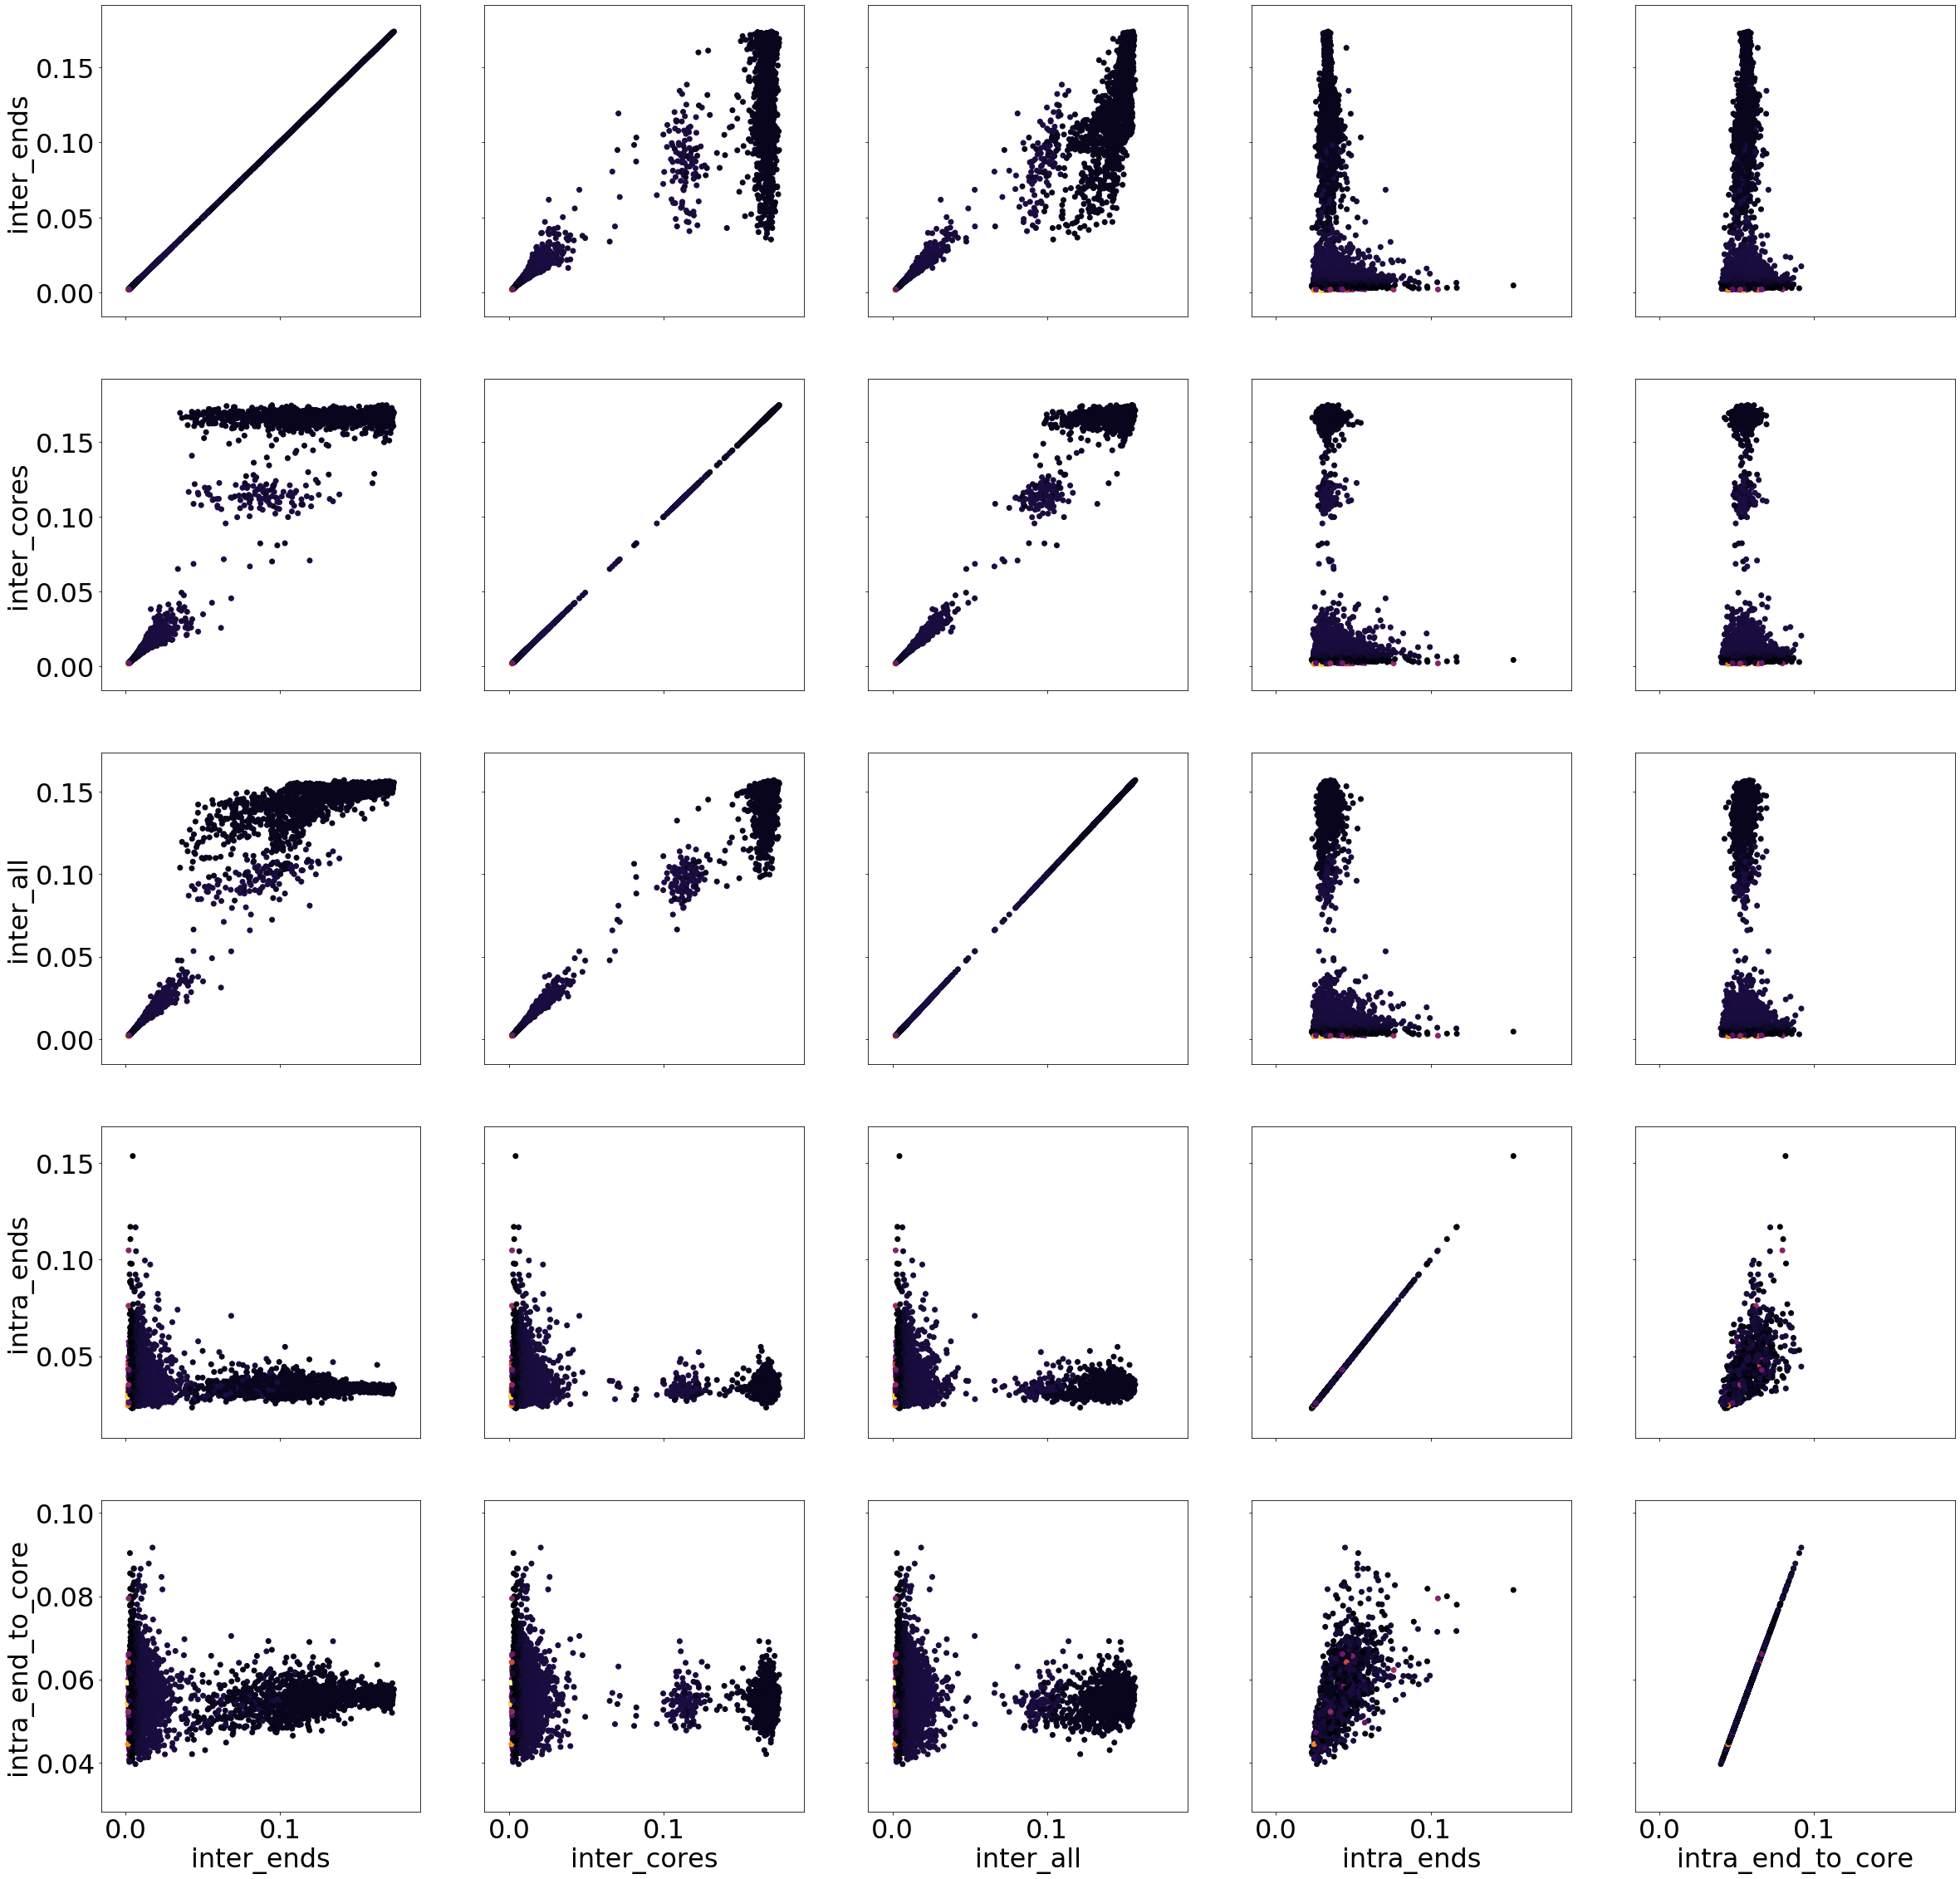

In [44]:
plot_subs(df, bp_match_dict, '3rd_EF')

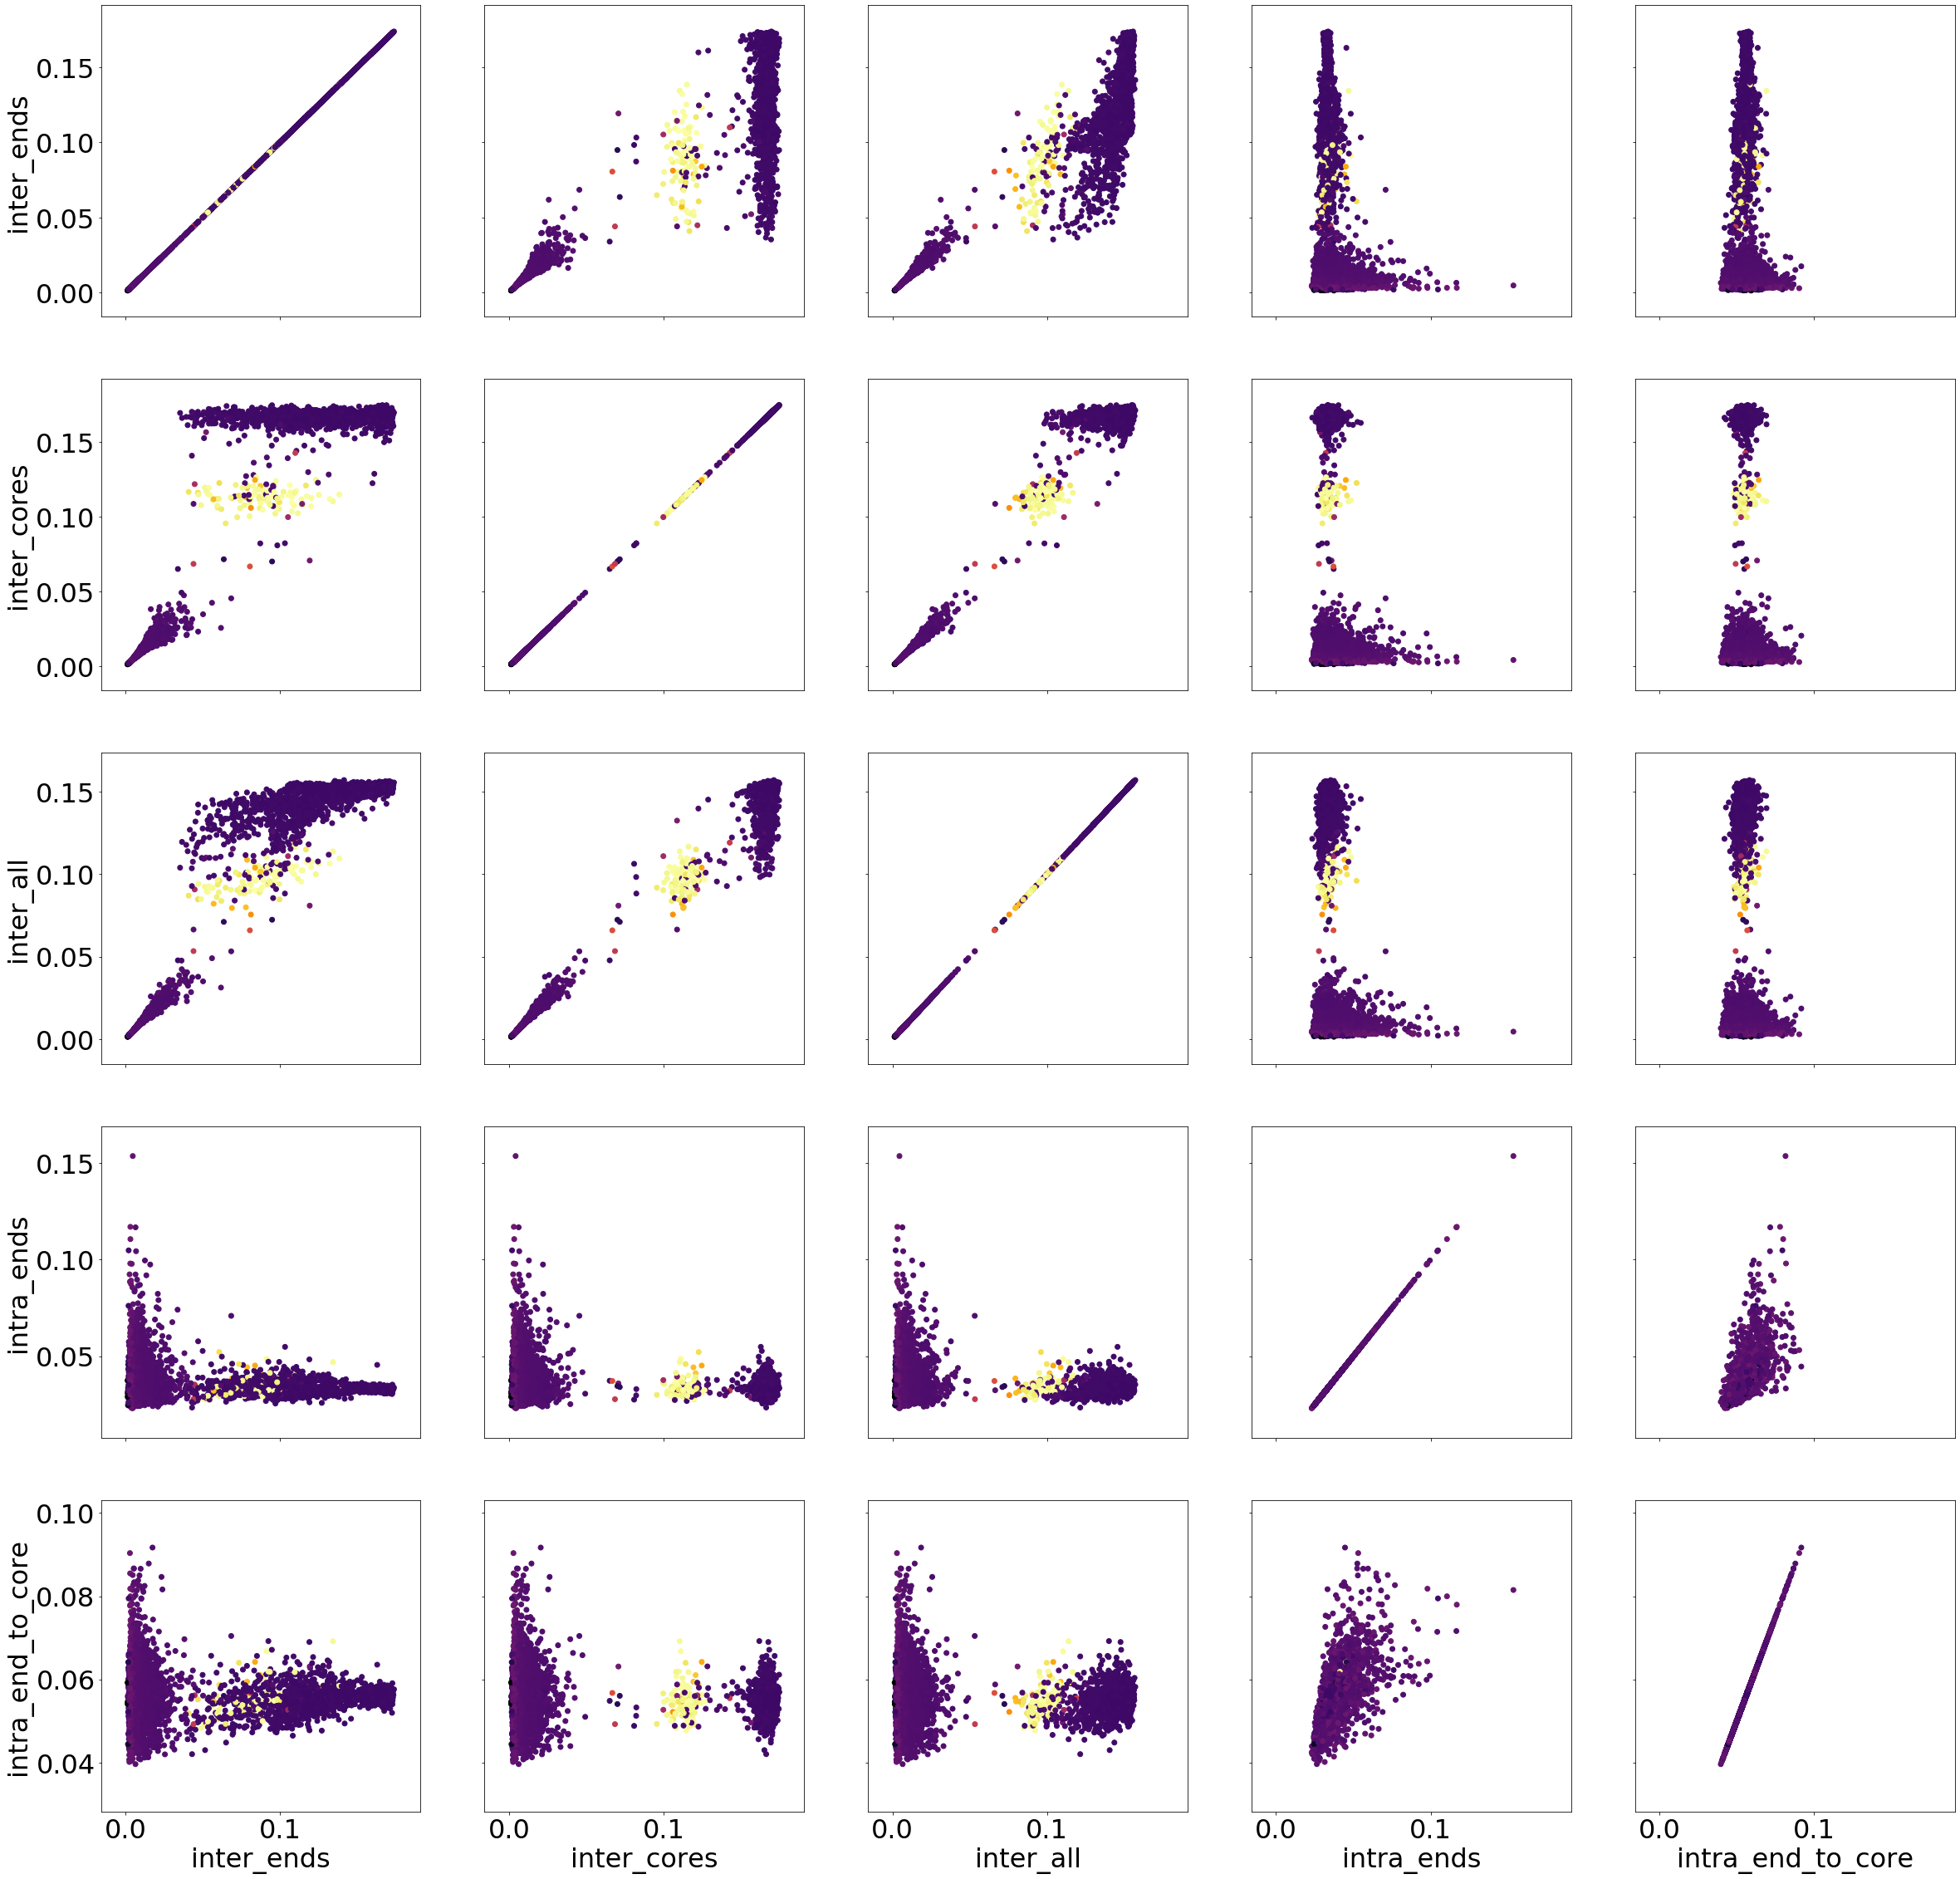

In [45]:
plot_subs(df, bp_match_dict, '4th_EF')

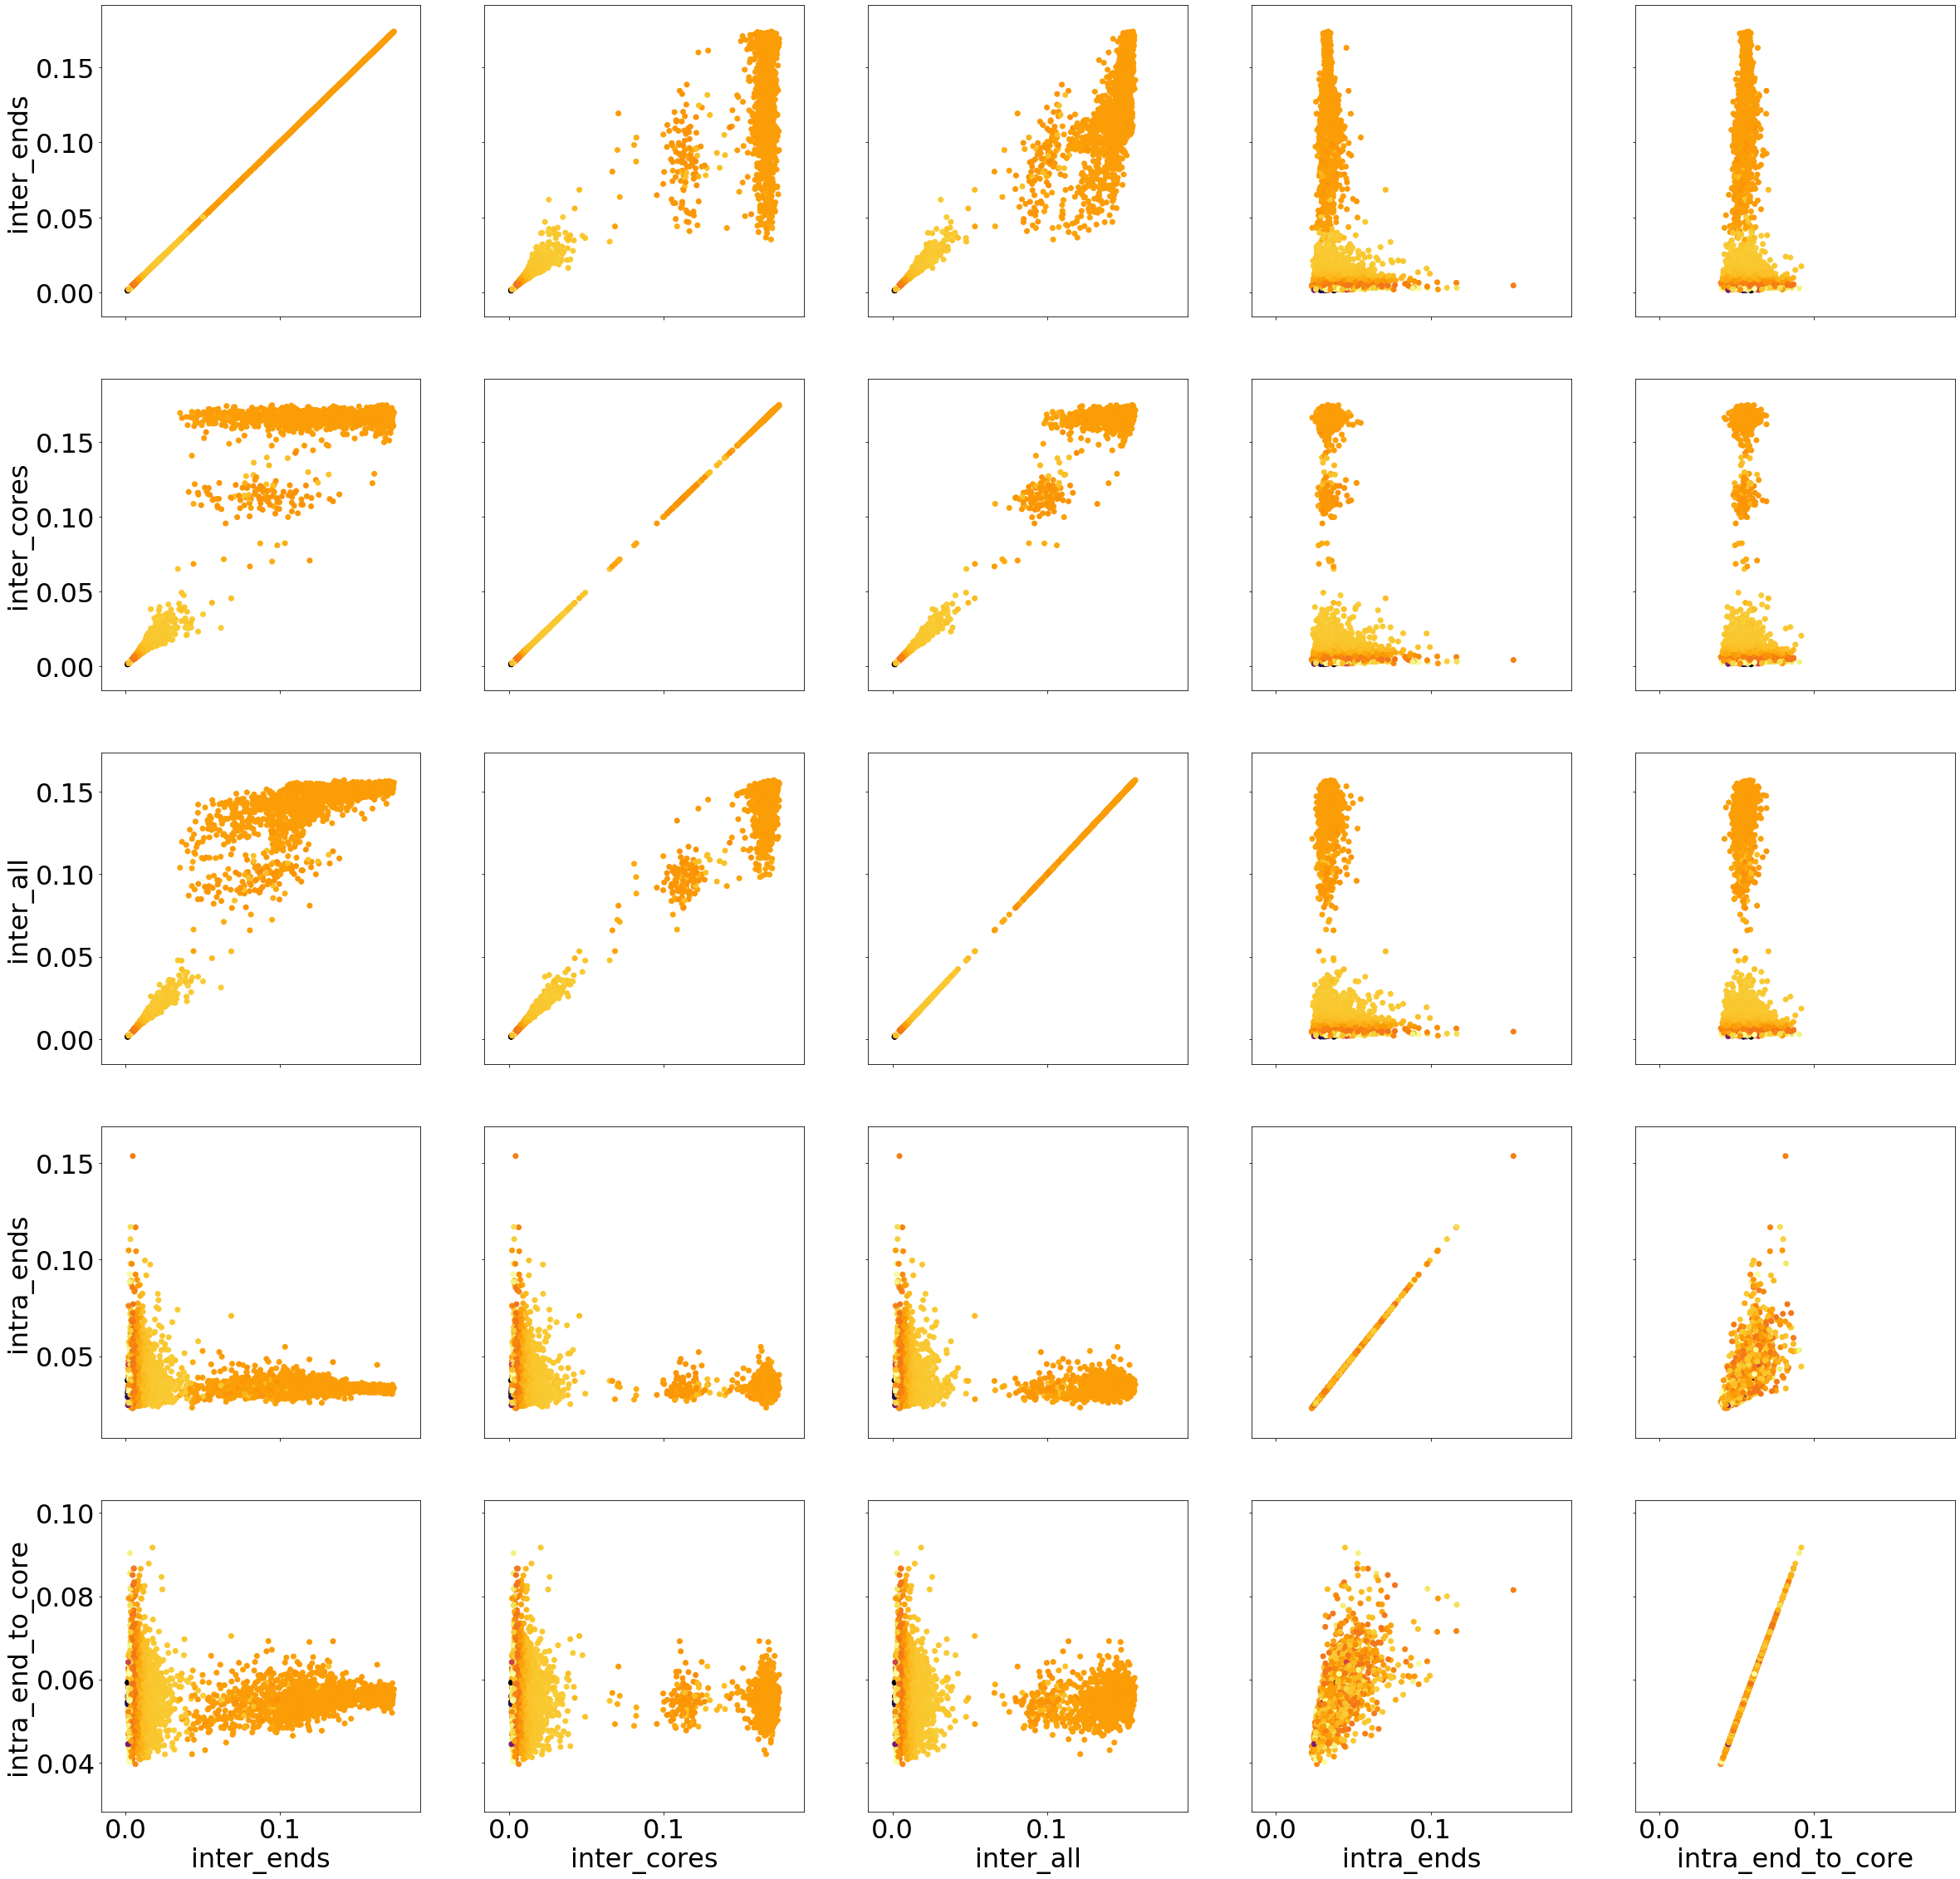

In [46]:
plot_subs(df, bp_match_dict, '5th_EF')

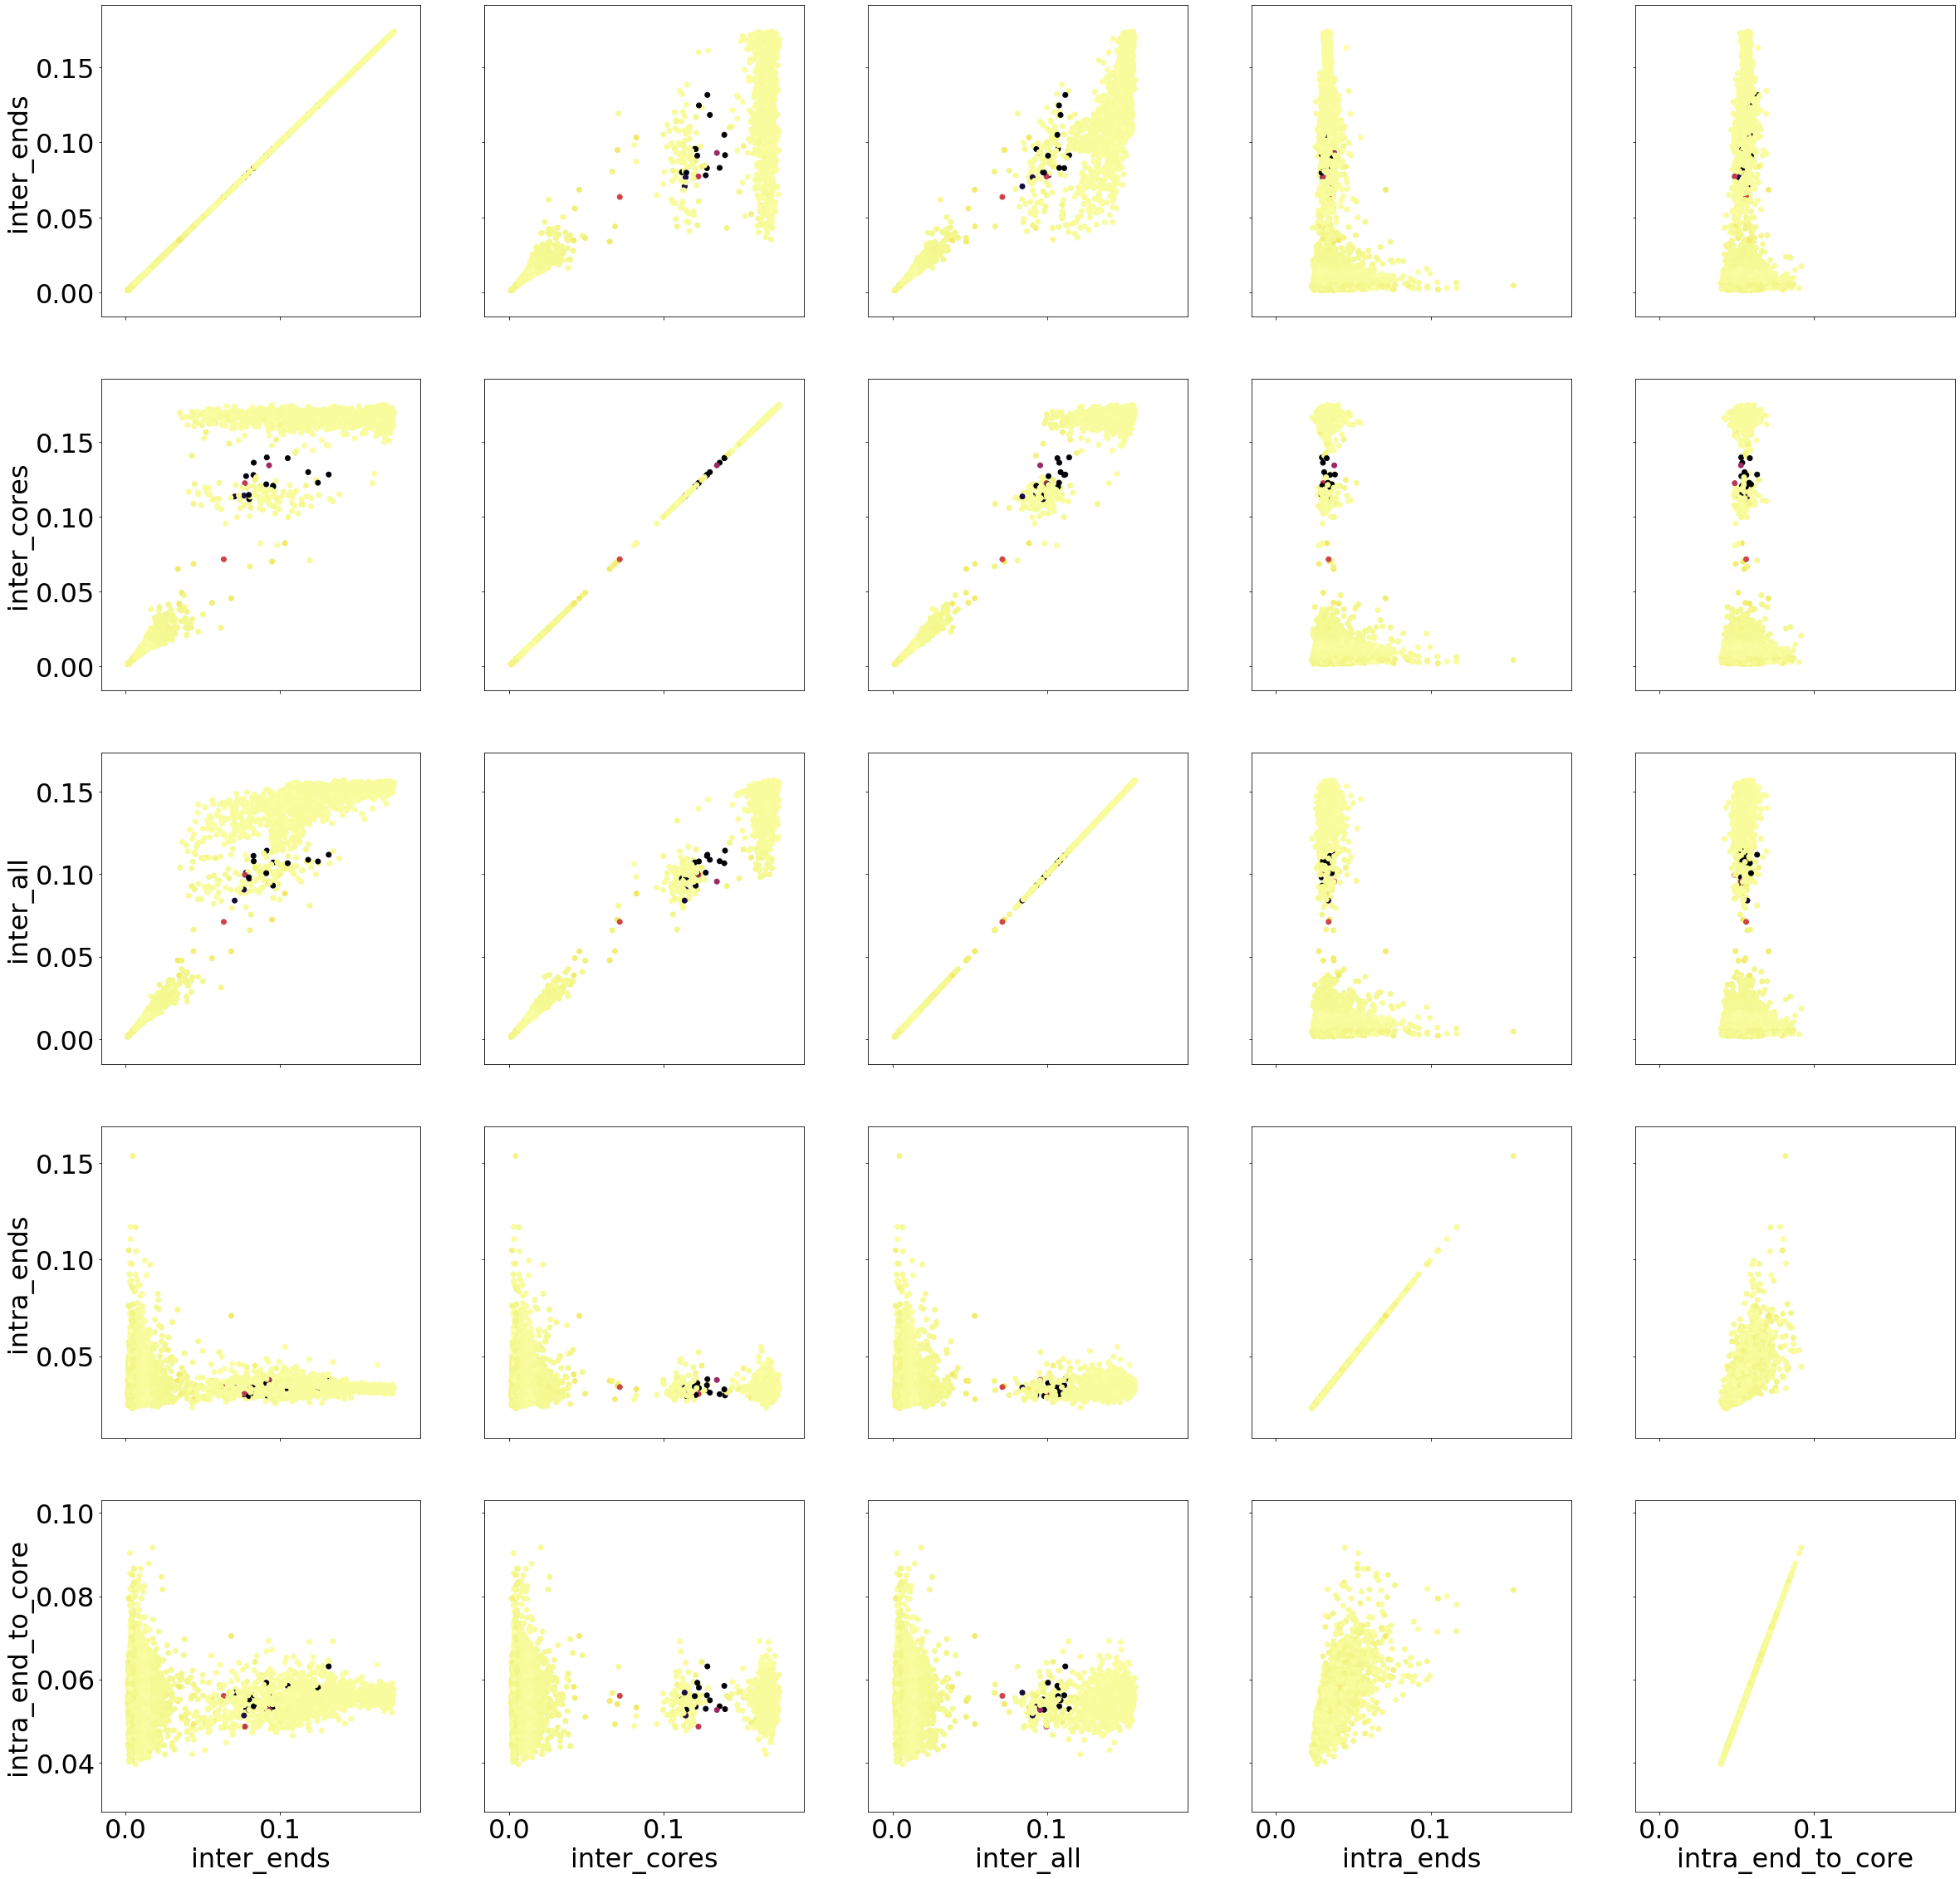

In [47]:
plot_subs(df, bp_match_dict, '6th_EF')

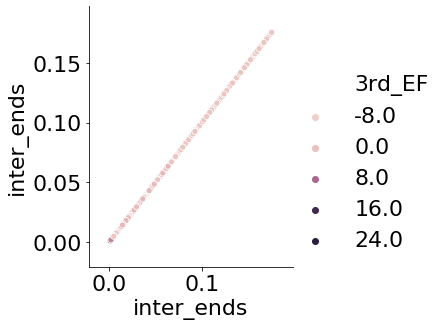

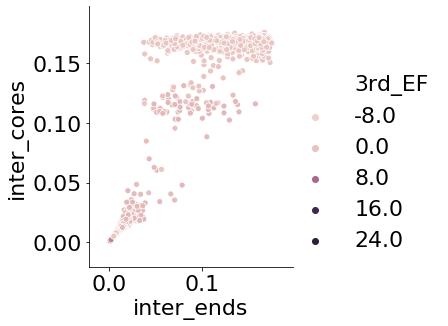

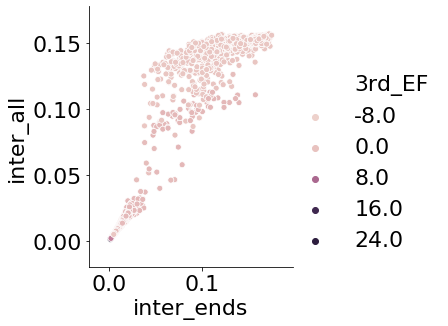

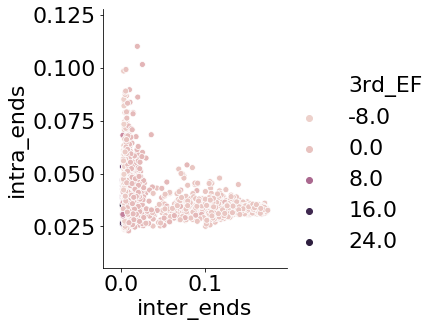

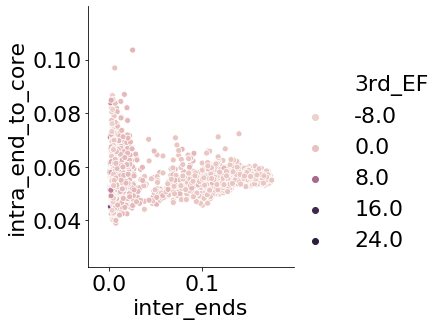

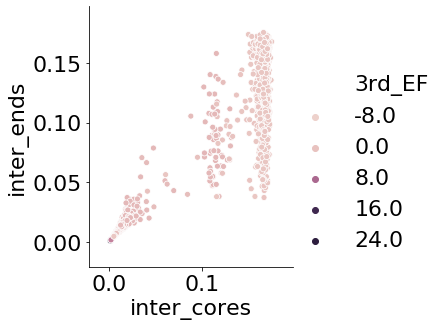

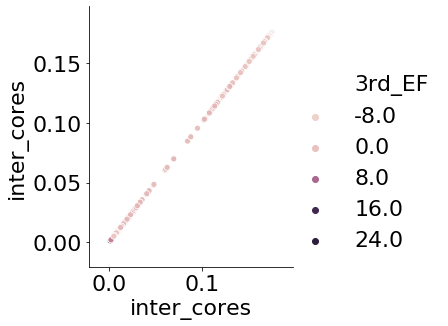

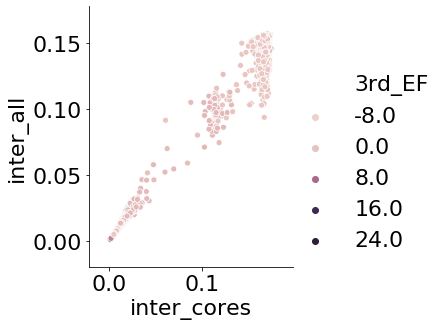

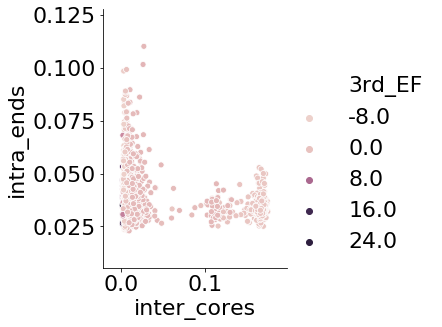

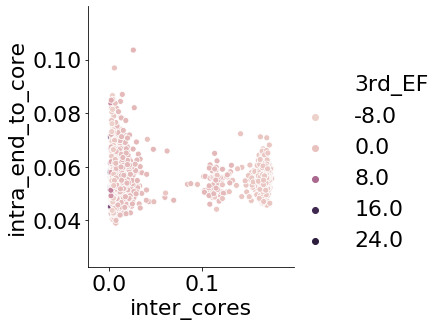

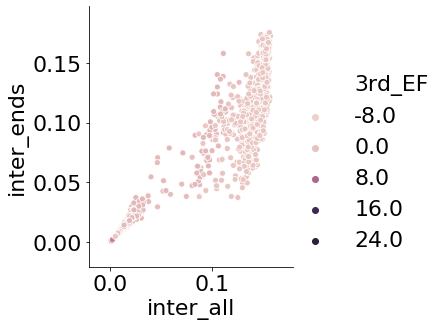

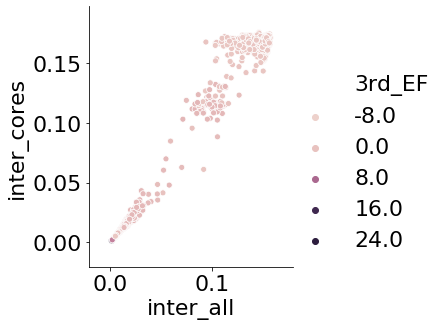

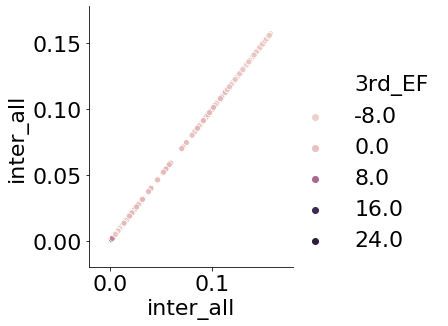

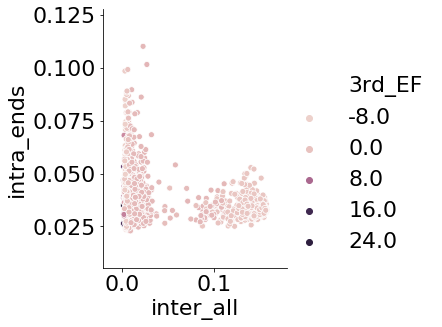

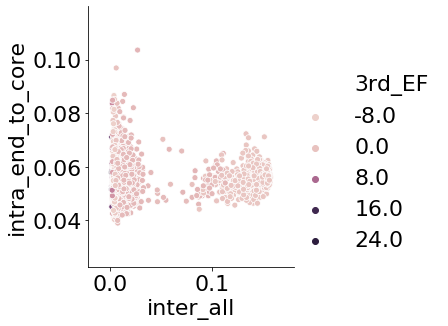

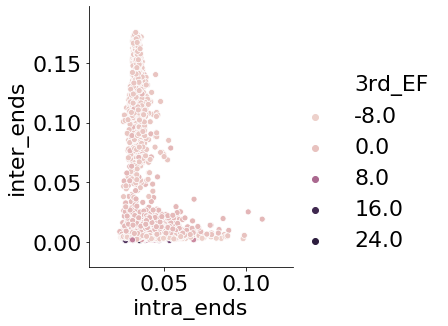

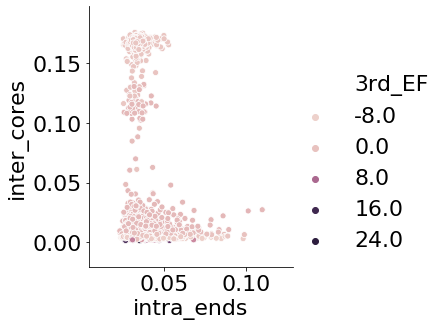

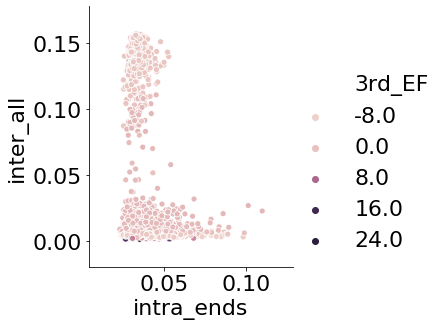

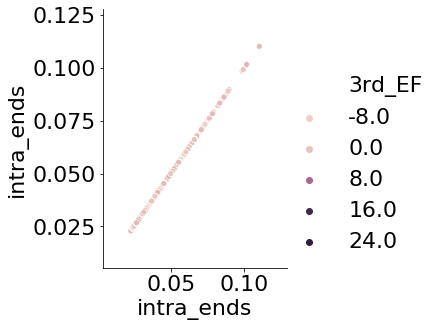

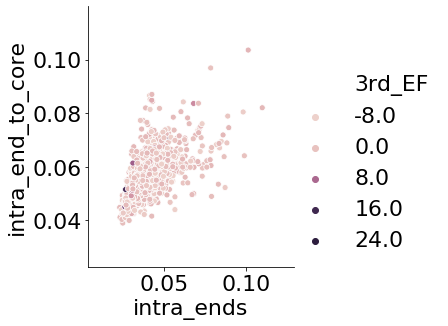

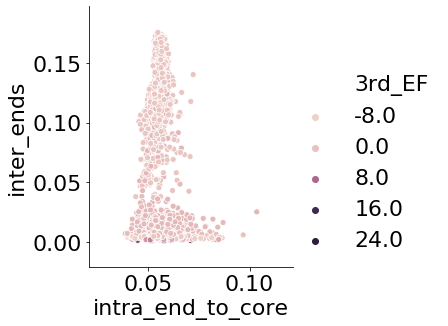

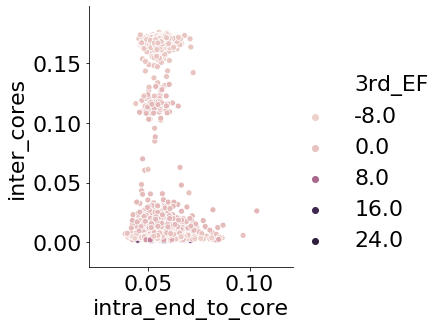

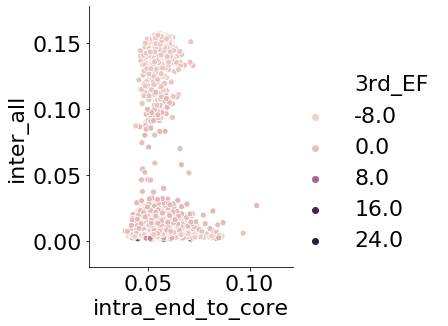

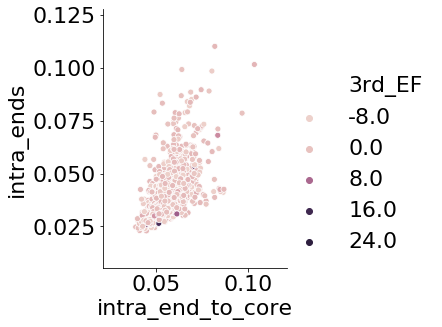

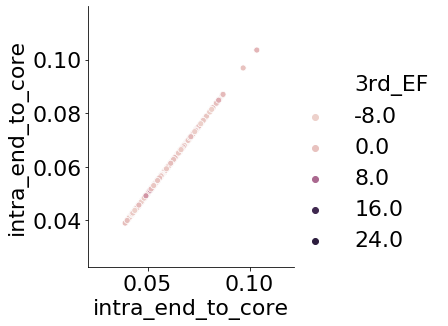

In [17]:
for k_i in bp_match_dict:
    for k_j in bp_match_dict:
        
        sns.relplot(data = df,
                    x = k_i, 
                    y = k_j, 
                    hue = "3rd_EF",
                    )